In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from prettytable import PrettyTable

In [ ]:
!unzip "/content/drive/MyDrive/Final Yr/videosCorrect-tamil.zip"

Archive:  /content/drive/MyDrive/Final Yr/videosCorrect-tamil.zip
  inflating: labelsCorrect-tamil.npy  
  inflating: videosCorrect-tamil.npy  


In [ ]:
videos = np.load('/content/videosCorrect-tamil.npy')
labels = np.load('/content/labelsCorrect-tamil.npy')

In [ ]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (482, 22, 80, 112, 3)
Labels shape: (482,)


In [ ]:
labels

array(['vanakkam', 'appa', 'podhum', 'unavu', 'appa', 'nanri', 'podhum',
       'udhavi', 'nanri', 'unavu', 'podhum', 'thungu', 'vanakkam',
       'udhavi', 'vanakkam', 'unavu', 'amma ', 'medhuvaga', 'iravu',
       'nanri', 'inru', 'thungu', 'udhavi', 'iravu', 'amma ', 'kudikka',
       'unavu', 'kudikka', 'vanakkam', 'inru', 'unavu', 'amma ', 'amma ',
       'appa', 'unavu', 'udhavi', 'udhavi', 'nanri', 'inru', 'nanri',
       'udhavi', 'udhavi', 'unavu', 'udhavi', 'unavu', 'thungu', 'inru',
       'vanakkam', 'appa', 'medhuvaga', 'iravu', 'inru', 'udhavi', 'inru',
       'thungu', 'inru', 'thungu', 'podhum', 'appa', 'udhavi', 'amma ',
       'amma ', 'inru', 'udhavi', 'thungu', 'appa', 'thungu', 'medhuvaga',
       'unavu', 'nanri', 'nanri', 'iravu', 'unavu', 'kudikka', 'podhum',
       'amma ', 'kudikka', 'kudikka', 'unavu', 'nanri', 'unavu', 'thungu',
       'kudikka', 'unavu', 'iravu', 'udhavi', 'thungu', 'podhum',
       'udhavi', 'amma ', 'podhum', 'inru', 'iravu', 'vanakkam', 

In [ ]:
words = list(set(list(labels)))
words.sort()
print(words)

['amma ', 'appa', 'inru', 'iravu', 'kudikka', 'medhuvaga', 'nanri', 'podhum', 'thungu', 'udhavi', 'unavu', 'vanakkam']


In [ ]:
label_dict = dict()
for i,j in enumerate(words):
    label_dict[i]=j
    print(label_dict[i],i)

amma  0
appa 1
inru 2
iravu 3
kudikka 4
medhuvaga 5
nanri 6
podhum 7
thungu 8
udhavi 9
unavu 10
vanakkam 11


In [ ]:
print(label_dict)

{0: 'amma ', 1: 'appa', 2: 'inru', 3: 'iravu', 4: 'kudikka', 5: 'medhuvaga', 6: 'nanri', 7: 'podhum', 8: 'thungu', 9: 'udhavi', 10: 'unavu', 11: 'vanakkam'}


In [ ]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = encoded_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (385, 22, 80, 112, 3) (385,)
Test set shape: (97, 22, 80, 112, 3) (97,)


In [ ]:
gc.collect()
!cat /proc/meminfo | grep Mem

MemTotal:       87532096 kB
MemFree:        72992956 kB
MemAvailable:   80723608 kB


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization, Dropout, LSTM, Reshape,Bidirectional
from tensorflow.keras import regularizers

input_shape = (22, 80, 112, 3)

model = Sequential()

# Convolutional layers with Batch Normalization and Dropout
model.add(Conv3D(16, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

# Reshape to fit LSTM input requirements
model.add(Reshape((-1, 64)))

# Recurrent Layer (LSTM)
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))

# Dense layers with Dropout
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(12, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert the target labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 78, 110, 16)   1312      
                                                                 
 batch_normalization_3 (Bat  (None, 20, 78, 110, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 10, 39, 55, 16)    0         
 g3D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 10, 39, 55, 16)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 37, 53, 32)     13856     
                                                                 
 batch_normalization_4 (Bat  (None, 8, 37, 53, 32)    

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

best_weights_path = 'model_weights-tamil.h5'
# Define the ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define the EarlyStopping callback to stop training if val_accuracy doesn't improve for patience number of epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

In [ ]:
# Train the model and record the history of training
history = model.fit(X_train, y_train_onehot, epochs=150  ,validation_data=(X_test, y_test_onehot),callbacks=[checkpoint])

Epoch 1/150
12/13 [==========================>...] - ETA: 0s - loss: 0.6094 - accuracy: 0.9557
Epoch 1: val_accuracy did not improve from 0.84536
13/13 [==============================] - 2s 168ms/step - loss: 0.6113 - accuracy: 0.9532 - val_loss: 1.8810 - val_accuracy: 0.6082
Epoch 2/150
12/13 [==========================>...] - ETA: 0s - loss: 1.0854 - accuracy: 0.8255
Epoch 2: val_accuracy did not improve from 0.84536
13/13 [==============================] - 1s 97ms/step - loss: 1.0840 - accuracy: 0.8260 - val_loss: 2.6432 - val_accuracy: 0.3814
Epoch 3/150
12/13 [==========================>...] - ETA: 0s - loss: 0.8210 - accuracy: 0.8828
Epoch 3: val_accuracy did not improve from 0.84536
13/13 [==============================] - 1s 94ms/step - loss: 0.8238 - accuracy: 0.8805 - val_loss: 3.6013 - val_accuracy: 0.3608
Epoch 4/150
12/13 [==========================>...] - ETA: 0s - loss: 0.8016 - accuracy: 0.8724
Epoch 4: val_accuracy did not improve from 0.84536
13/13 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/13 [==========================>...] - ETA: 0s - loss: 0.5336 - accuracy: 0.9714
Epoch 26: val_accuracy did not improve from 0.87629
13/13 [==============================] - 1s 96ms/step - loss: 0.5446 - accuracy: 0.9688 - val_loss: 0.8851 - val_accuracy: 0.8660
Epoch 27/150
12/13 [==========================>...] - ETA: 0s - loss: 0.7250 - accuracy: 0.9193
Epoch 27: val_accuracy did not improve from 0.87629
13/13 [==============================] - 1s 94ms/step - loss: 0.7249 - accuracy: 0.9195 - val_loss: 1.8912 - val_accuracy: 0.6082
Epoch 28/150
12/13 [==========================>...] - ETA: 0s - loss: 0.7545 - accuracy: 0.9245
Epoch 28: val_accuracy did not improve from 0.87629
13/13 [==============================] - 1s 97ms/step - loss: 0.7537 - accuracy: 0.9247 - val_loss: 3.3425 - val_accuracy: 0.2680
Epoch 29/150
12/13 [==========================>...] - ETA: 0s - loss: 0.6136 - accuracy: 0.9453
Epoch 29: val_accuracy did not improve from 0.87629
13/13 [========================

In [ ]:
model.load_weights(best_weights_path)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

4/4 [==============================] - 0s 33ms/step


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-----------+-----------+--------+----------+---------+
|   Class   | Precision | Recall | F1-Score | Support |
+-----------+-----------+--------+----------+---------+
|   amma    |    0.91   |  1.0   |   0.95   |    10   |
|    appa   |    1.0    |  1.0   |   1.0    |    7    |
|    inru   |    1.0    |  1.0   |   1.0    |    9    |
|   iravu   |    0.86   |  1.0   |   0.92   |    6    |
|  kudikka  |    1.0    |  0.9   |   0.95   |    10   |
| medhuvaga |    0.86   |  1.0   |   0.92   |    6    |
|   nanri   |    1.0    |  1.0   |   1.0    |    10   |
|   podhum  |    1.0    |  1.0   |   1.0    |    3    |
|   thungu  |    1.0    |  1.0   |   1.0    |    9    |
|   udhavi  |    1.0    |  1.0   |   1.0    |    7    |
|   unavu   |    1.0    |  0.92  |   0.96   |    12   |
|  vanakkam |    1.0    |  0.88  |   0.93   |    8    |
+-----------+-----------+--------+----------+---------+


In [ ]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred)*100)

Balanced accuracy: 97.43055555555556


4/4 [==============================] - 0s 33ms/step


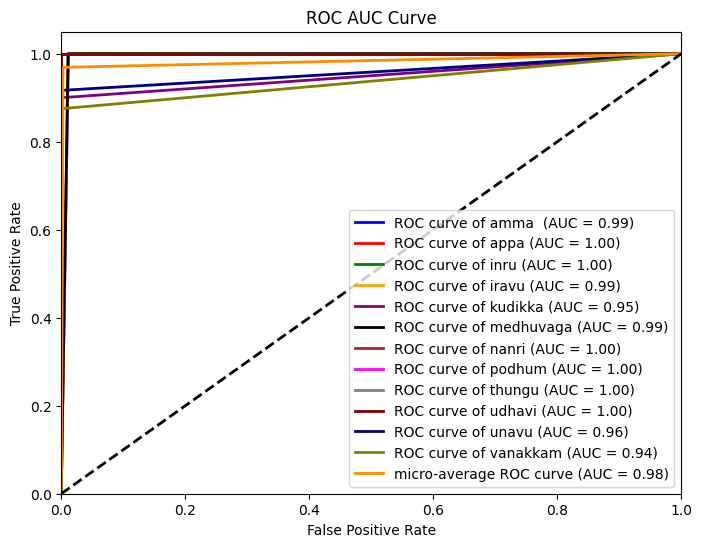

In [ ]:
# Convert y_true and y_pred to one-hot encoding
n_classes = len(np.unique(y_test))
y_true_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = model.predict(X_test)
y_pred_bin = label_binarize(np.argmax(y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8,6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

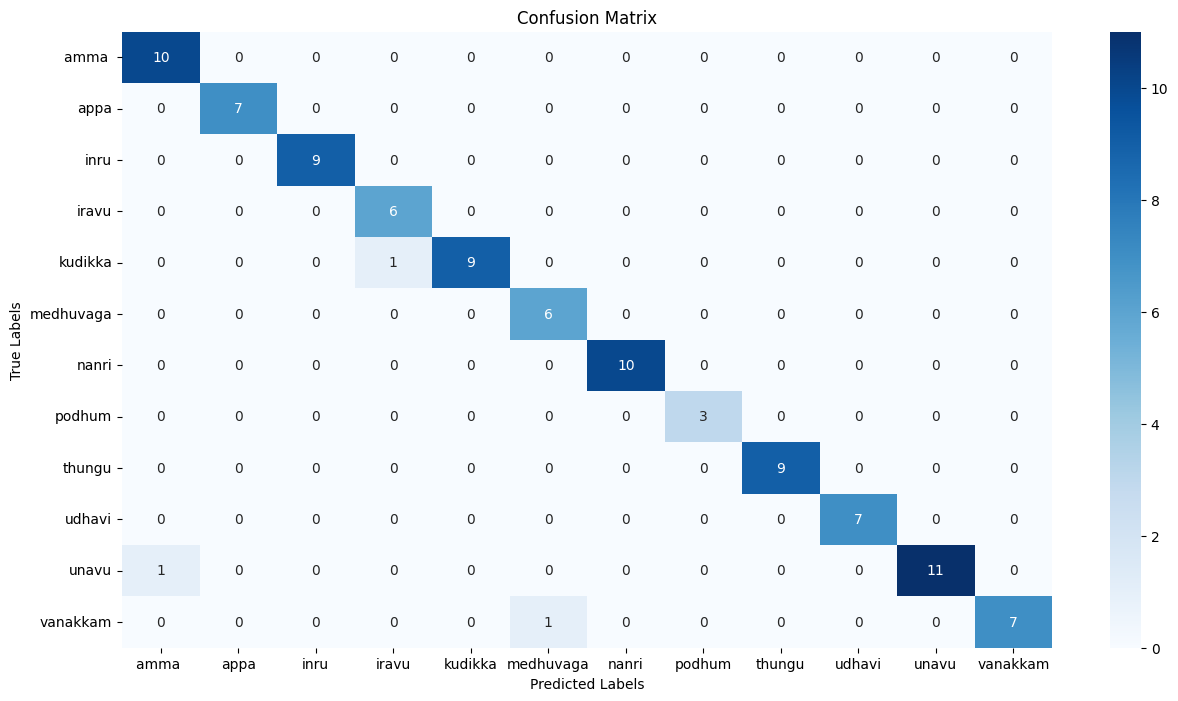

In [ ]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
plt.figure(figsize=(15,8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()